In [71]:
# Basic libraries
import pandas  as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

# Library to handle text data
import nltk

# Library for data pre-processing
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# library to split data into train and test
from sklearn.model_selection import train_test_split

# library to transform data - Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# library for dimensionality reduction - feature reduction 
from sklearn.decomposition import TruncatedSVD, PCA

# library to build model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

# library to get accuracy report - model validation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [72]:
# reading dataset into train and test

train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
submission = pd.read_csv("dataset/sample_sub.csv")

# merging train and test datasets to perform data pre-processing
data=pd.concat([train, test], axis=0)

In [73]:
# check data
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [74]:
data.tail()

,id,keyword,location,text,target
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [75]:
# checking dimensions of the dataset
print("train:", train.shape)
print("test:",test.shape)
print("data:", data.shape)


train: (7613, 5)
test: (3263, 4)
data: (10876, 5)


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10876 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 509.8+ KB


In [77]:
data.isna().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

The value count target variable 
0.0    4342
1.0    3271
Name: target, dtype: int64


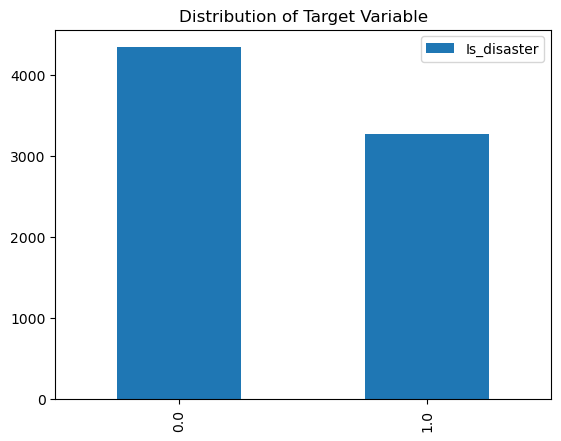

In [78]:
# Check for distribution of target variable. 

print("The value count target variable ")
print(data.target.value_counts())

data.target.value_counts().plot(kind='bar', label='Is_disaster')
plt.title("Distribution of Target Variable")
plt.legend()
plt.show()

# Data Pre-processing

Mean length of text when Disaster: 108.11342097217977
Mean length of text when No Disaster: 95.70681713496084


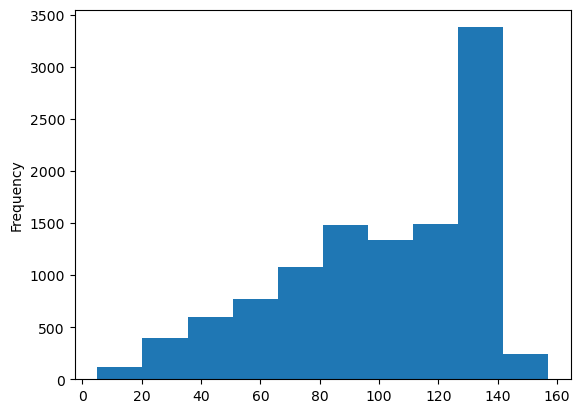

In [79]:
# check whether length of tweets has any relation with the occurance of disaster

# length column to contain the length of text column
data['length'] = data['text'].apply(lambda x: len(x))

# mean length of tweets when there is a disaster and not a disaster
print("Mean length of text when Disaster:",data[data['target']==1].length.mean())
print("Mean length of text when No Disaster:",data[data['target']==0].length.mean()) 

# distribution of length of tweet 
data['length'].plot(kind='hist')
plt.show()

observation: clearly when there is a disaster, people tends to tweet longer 

In [80]:
# check whether people uses more # word when disaster 


# creating a column, which contains only the words that start with #
data["#word"] = data['text'].apply(lambda x: list(word for word in x.split() if word[0]=='#'))

# count the number of words that starts with # in text column
data['number_of_#words']=data['#word'].apply(lambda x: len(x))

# check averange numbr of #words in tweet with disaster and not disaster
print("Average number of #words in tweeets from Disaster",data[(data['target']==1) & (data['number_of_#words']!=0)]['number_of_#words'].mean())
print("Average number of #words in tweeets from No Disaster",data[(data['target']==0) & (data['number_of_#words']!=0)]['number_of_#words'].mean())

Average number of #words in tweeets from Disaster 1.9428238039673278
Average number of #words in tweeets from No Disaster 1.9099201824401368


Observation: Clearly not much of a relation exist between people using # words and disaster

In [81]:
# converting the text data into all lower case

data['text']=data['text'].apply(lambda x: x.lower())

In [82]:
# special character removeal

def remove_special_characters(text):
    """ function that remove any or all the special character provided in a string format
    takes each tweet as an input and 
    returns the clean tweet
    """

    # Define a list of special characters to remove
    special_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"

    # Remove special characters using str.translate() method
    cleaned_text = text.translate(str.maketrans('', '', special_chars))
    return cleaned_text


# the processed text in a new column so that we can compare the changes made while cleaning the data
data['processed_text']=data['text'].apply(lambda x: remove_special_characters(x))

data.head()

,id,keyword,location,text,target,length,#word,number_of_#words,processed_text
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1.0,69,[#earthquake],1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,forest fire near la ronge sask. canada,1.0,38,[],0,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1.0,133,[],0,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65,[#wildfires],1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1.0,88,"[#Alaska, #wildfires]",2,just got sent this photo from ruby alaska as s...


In [83]:
# removing stopwords

# using stopwords dictionary from NLTK library
stop= stopwords.words('english')

# the lambda function takes each tweet, split it and if any of the word not in stopword dictionary, than join back with a white space
data['processed_text'] = data['processed_text'].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))

In [84]:
# Stemming to get root words

# stemming using stem.PorterStemmer function from NLTK library
stem = PorterStemmer()
# lambda function applied on the processed text column
# takes each tweet and split it. and uses stem.stem from PorterStemmer to get the root word
# the resultant word is than joined back to form a sentense
pd.DataFrame(data['processed_text'].apply(lambda x: " ".join([stem.stem(word) for word in x.split()])))

# the changes made are not stored but only viewed 


,processed_text
0,deed reason earthquak may allah forgiv us
1,forest fire near la rong sask canada
2,resid ask shelter place notifi offic evacu she...
3,13000 peopl receiv wildfir evacu order california
4,got sent photo rubi alaska smoke wildfir pour ...
...,...
3258,earthquak safeti lo angel ûò safeti fasten xrwn
3259,storm ri wors last hurrican cityamp3oth hardes...
3260,green line derail chicago httptcoutbxlcbiuy
3261,meg issu hazard weather outlook hwo httptco3x6...


In [85]:
# lemmatization get the base word 

# using WordNetLemmatizer() from NLTK.stem  library
lem = WordNetLemmatizer()
# just like stemming, words are lemmatize instead of stemming.
data['processed_text'] = data['processed_text'].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

In [86]:
data

,id,keyword,location,text,target,length,#word,number_of_#words,processed_text
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1.0,69,[#earthquake],1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,forest fire near la ronge sask. canada,1.0,38,[],0,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1.0,133,[],0,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65,[#wildfires],1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1.0,88,"[#Alaska, #wildfires]",2,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...,NaN,55,[],0,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,storm in ri worse than last hurricane. my city...,NaN,139,[],0,storm ri worse last hurricane cityamp3others h...
3260,10868,NaN,NaN,green line derailment in chicago http://t.co/u...,NaN,55,[],0,green line derailment chicago httptcoutbxlcbiuy
3261,10874,NaN,NaN,meg issues hazardous weather outlook (hwo) htt...,NaN,65,[],0,meg issue hazardous weather outlook hwo httptc...


In [87]:
# Removing URLs from the tweet text data if any

def remove_urls(text):
    pattern = r'http\S+'  # Regex pattern to match URLs
    cleaned_text = re.sub(pattern, '', text) # substituting with '' if the pattern is found in text
    return cleaned_text  

data['processed_text']=data['processed_text'].apply(remove_urls)

<AxesSubplot:ylabel='Frequency'>

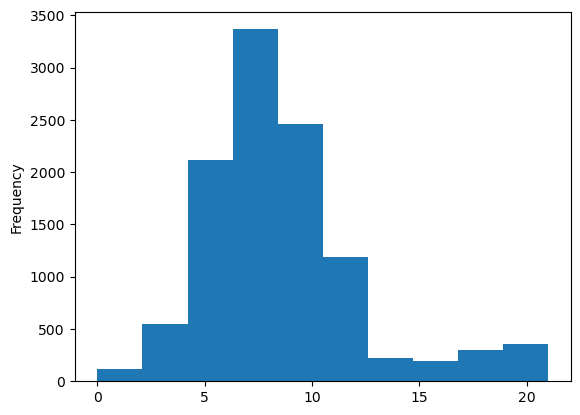

In [88]:
# playing with length of keyword 

# since NaN value in the column, so we replace NaN value with white space
for index, row in data.iterrows():
    value = row['keyword']  
    
    # Check if the value is NaN
    if pd.isna(value):
        data.at[index, 'keyword'] = ''  # replace the NaN locatino in keyword column with ''


data['keyword_length']=data['keyword'].apply(lambda x: len(x))
data['keyword_length'].plot(kind='hist')

# Train-test-validation split data

In [89]:
# spliting test data from the combined data first
i = train.shape[0]
train = data[:i]
test = data[i:]

# x,y as the independent and dependent variable respectively
x=train[['processed_text','length']]
y=train['target']
test = test[['processed_text','length']]


# spliting train and validation data, with 20% of data for validation andrest is for training 
x_train,  x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=42)

# Feature extraction on text column 

In [90]:
def feature_extraction(fe):
    """ Function to perform the feature extraction, 
    takes instance of feature reduction technique as argument
    returns the array of transformed data
    """
    print("Feature Extraction using:",fe)
    # transforming data
    fe.fit(x_train['processed_text'])

    x_train_fe = fe.transform(x_train['processed_text']).toarray()
    x_val_fe = fe.transform(x_val['processed_text']).toarray()
    test_fe = fe.transform(test['processed_text']).toarray()
    
    return(x_train_fe, x_val_fe, test_fe)


max_feature = 3000 # max length of feature extracted

# using CountVectorizer and TfidfVectorizer function from sklearn.feature_extraction.text library
cv = CountVectorizer(max_features=max_feature)
tfidf = TfidfVectorizer(max_features=max_feature)

x_train_fe, x_val_fe, test_fe = feature_extraction(tfidf)

Feature Extraction using: TfidfVectorizer(max_features=3000)


# Feature reduction

In [91]:
def reduce_dimension(technique):
    """ function to reduce the dimension of the transfored text column
    takes instance of the method used to reduce dimension
    return the column with reduced dimensions
    """
    
    print("Feature Reduction:", technique)
    technique.fit(x_train_fe)
    
    x_train_fe_r = technique.transform(x_train_fe)
    x_val_fe_r = technique.transform(x_val_fe)

    test_fe_r = technique.transform(test_fe)

    return( x_train_fe_r, x_val_fe_r, test_fe_r)



n=7   # Specifing the number of components to keep

# using PCA and TruncatedSVD function from sklearn.decomposition
svd = TruncatedSVD(n_components=n)  
pca = PCA(n_components=n)

x_train_fe_r, x_val_fe_r, test_fe_r = reduce_dimension(pca)

Feature Reduction: PCA(n_components=7)


# Building model for predictions

In [92]:
# Logistic Regression

# creating instance
lr = LogisticRegression()
# training model
lr.fit(x_train_fe, y_train)
# predicting for training data and validation set
lr_pred_train = lr.predict(x_train_fe)
lr_pred = lr.predict(x_val_fe)

# report:
print(f"classification_report:(Train - {lr})")
print(classification_report(lr_pred_train,y_train))
print(f"\n Classification Report: (Validation - {lr})")
print(classification_report(lr_pred, y_val))

classification_report:(Train - LogisticRegression())
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89      3872
         1.0       0.77      0.91      0.83      2218

    accuracy                           0.87      6090
   macro avg       0.86      0.88      0.86      6090
weighted avg       0.88      0.87      0.87      6090


 Classification Report: (Validation - LogisticRegression())
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84       961
         1.0       0.70      0.81      0.75       562

    accuracy                           0.80      1523
   macro avg       0.79      0.80      0.79      1523
weighted avg       0.81      0.80      0.80      1523



In [93]:
# DecisionTreeClassifier


# creating instance
dtc = DecisionTreeClassifier()
# training model
dtc.fit(x_train_fe, y_train)
# predicting for training data and validation set
dtc_pred_train = dtc.predict(x_train_fe)
dtc_pred = dtc.predict(x_val_fe)

# report:
print("classification_report:(Train)")
print(classification_report(dtc_pred_train,y_train))
print("\n Classification Report: (Validation)")
print(classification_report(dtc_pred, y_val))

classification_report:(Train)
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      3545
         1.0       0.97      1.00      0.98      2545

    accuracy                           0.98      6090
   macro avg       0.98      0.99      0.98      6090
weighted avg       0.98      0.98      0.98      6090


 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75       856
         1.0       0.68      0.66      0.67       667

    accuracy                           0.71      1523
   macro avg       0.71      0.71      0.71      1523
weighted avg       0.71      0.71      0.71      1523



In [94]:
# RandomForestClassifier

# creating instance
rfc = RandomForestClassifier(n_estimators=500, random_state=42)
# training model
rfc.fit(x_train_fe, y_train)
# predicting for training data and validation set
rfc_pred_train = rfc.predict(x_train_fe)
rfc_pred = rfc.predict(x_val_fe)

# report:
print("classification_report:(Train)")
print(classification_report(rfc_pred_train,y_train))
print("Accracy Score: Training set",accuracy_score(rfc_pred_train,y_train))
print("\n Classification Report: (Validation)")
print(classification_report(rfc_pred, y_val))
print("Accuracy Score: Validation set", accuracy_score(rfc_pred, y_val))

classification_report:(Train)
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      3521
         1.0       0.97      0.99      0.98      2569

    accuracy                           0.98      6090
   macro avg       0.98      0.99      0.98      6090
weighted avg       0.98      0.98      0.98      6090

Accracy Score: Training set 0.984072249589491

 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.82      0.79      0.81       910
         1.0       0.71      0.75      0.73       613

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Accuracy Score: Validation set 0.7754432042022325


In [95]:
# svm

# creating instance
svm = svm.SVC()
# training model
svm.fit(x_train_fe, y_train)
# predicting for training data and validation set
svm_pred_train = svm.predict(x_train_fe)
svm_pred = svm.predict(x_val_fe)

# report:
print("classification_report:(Train)")
print(classification_report(svm_pred_train,y_train))
print("Accracy Score: Training set",accuracy_score(svm_pred_train,y_train))
print("\n Classification Report: (Validation)")
print(classification_report(svm_pred, y_val))
print("Accuracy Score: Validation set", accuracy_score(svm_pred, y_val))

classification_report:(Train)
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      3681
         1.0       0.90      0.98      0.94      2409

    accuracy                           0.95      6090
   macro avg       0.94      0.95      0.95      6090
weighted avg       0.95      0.95      0.95      6090

Accracy Score: Training set 0.9486042692939245

 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84       980
         1.0       0.69      0.82      0.75       543

    accuracy                           0.80      1523
   macro avg       0.79      0.81      0.79      1523
weighted avg       0.82      0.80      0.80      1523

Accuracy Score: Validation set 0.8017071569271176


In [96]:
# creating instance
mnb = MultinomialNB()
# training model
mnb.fit(x_train_fe, y_train)
# predicting for training data and validation set
mnb_pred_train = mnb.predict(x_train_fe)
mnb_pred = mnb.predict(x_val_fe)

# report:
print("classification_report:(Train)")
print(classification_report(mnb_pred_train,y_train))
print("Accracy Score: Training set",accuracy_score(mnb_pred_train,y_train))
print("\n Classification Report: (Validation)")
print(classification_report(mnb_pred, y_val))
print("Accuracy Score: Validation set", accuracy_score(mnb_pred, y_val))

classification_report:(Train)
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88      3904
         1.0       0.75      0.90      0.81      2186

    accuracy                           0.85      6090
   macro avg       0.84      0.86      0.85      6090
weighted avg       0.87      0.85      0.86      6090

Accracy Score: Training set 0.8532019704433498

 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.87      0.79      0.83       972
         1.0       0.68      0.80      0.73       551

    accuracy                           0.79      1523
   macro avg       0.78      0.79      0.78      1523
weighted avg       0.80      0.79      0.79      1523

Accuracy Score: Validation set 0.7912015758371634


In [97]:
def build_model(model,
                x_train= x_train_fe,
                x_val=x_val_fe,
                x_test=test_fe):
    
    print("Model used:",model)
    # training model
    model.fit(x_train, y_train)
    # predicting for training data and validation set
    model_pred_train = model.predict(x_train)
    model_pred = model.predict(x_val)
    test_pred = model.predict(x_test)

    # report:
    #print("classification_report:(Train)")
    #print(classification_report(model_pred_train,y_train))
    #print("Accuracy Score:Training",accuracy_score(model_pred_train,y_train))
    print("\n Classification Report: (Validation)")
    print(classification_report(model_pred, y_val))
    print("Accuracy Score:",accuracy_score(model_pred, y_val))

    return (test_pred)



# Features extraction
maxf = 3000
cv = CountVectorizer(max_features=maxf)
tfidf = TfidfVectorizer(max_features=maxf)


n=7
svd = TruncatedSVD(n_components=n)  # Specify the number of components to keep
pca = PCA(n_components=n)



# model train and prediction
instance_lr = LogisticRegression()
instance_dtc = DecisionTreeClassifier()
instance_rfc = RandomForestClassifier(n_estimators=500, random_state=42)
#instance_svm = svm.SVC()
instance_mnb = MultinomialNB()




In [98]:
x_train_fe, x_val_fe, test_fe = feature_extraction(tfidf)
x_train_fe_r, x_val_fe_r, test_fe_r = reduce_dimension(pca)

print("Building model without frature reduction:")
sub_test_pred = build_model(instance_dtc, 
                        x_train= x_train_fe, 
                        x_val=x_val_fe, 
                        x_test=test_fe)

print("\nBuilding model after reducing features:")
test_pred = build_model(instance_dtc, 
                        x_train= x_train_fe_r, 
                        x_val=x_val_fe_r, 
                        x_test=test_fe_r)

Feature Extraction using: TfidfVectorizer(max_features=3000)
Feature Reduction: PCA(n_components=7)
Building model without frature reduction:
Model used: DecisionTreeClassifier()

 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75       853
         1.0       0.68      0.66      0.67       670

    accuracy                           0.71      1523
   macro avg       0.71      0.71      0.71      1523
weighted avg       0.71      0.71      0.71      1523

Accuracy Score: 0.7130663164806303

Building model after reducing features:
Model used: DecisionTreeClassifier()

 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.73      0.70      0.71       910
         1.0       0.57      0.61      0.59       613

    accuracy                           0.66      1523
   macro avg       0.65      0.65      0.65      1523
weighted avg       0.66      0.66

Observation: overall accuracy, f1-score reduces if we reduce the dimensions.

# Finalising Model

In [99]:
i = train.shape[0]
train = data[:i]
test = data[i:]

# Split the data into features (text and length) and target
X = train[['processed_text', 'length','number_of_#words','keyword_length']]
y = train['target']
test = test[['processed_text','length','number_of_#words','keyword_length']]

# Convert text to numerical representation using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=4800, ngram_range=(1, 2))
vectorizer.fit(X['processed_text'])
X_text = vectorizer.transform(X['processed_text'])
test_text = vectorizer.transform(test['processed_text'])

# Combine text and other features
X_combined = pd.concat([pd.DataFrame(X_text.toarray()), X[['length','number_of_#words','keyword_length']]], axis=1)
test_combined = pd.concat([pd.DataFrame(test_text.toarray()), test[['length','number_of_#words','keyword_length']]], axis=1)

# converting column name to string type
X_combined.columns = X_combined.columns.astype(str)
test_combined.columns = test_combined.columns.astype(str)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# Build and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report: (Validation)")
print(classification_report(y_test, y_pred))



# print(classification_report(y_test, y_pred))

Accuracy: 0.8109243697478992

Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84      1091
         1.0       0.83      0.70      0.76       813

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



/Users/ankitbaliyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
# preparing submission file
submission['target']=model.predict(test_combined)
submission['target'] = submission['target'].apply(lambda x: round(x))
print(submission.target.value_counts())
submission.head()

0    2112
1    1151
Name: target, dtype: int64


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,1
